In [59]:
using CSV, Plots, Random, LinearAlgebra, Statistics, DataFrames

In [60]:
zoom = CSV.read("ZM_adjclose.csv")
facebook = CSV.read("FB_adjclose.csv")
amazon = CSV.read("AMZN_adjclose.csv")
cisco = CSV.read("CSCO_adjclose.csv")
netflix = CSV.read("NFLX_adjclose.csv")
intel = CSV.read("INTC_adjclose.csv")
tesla = CSV.read("TSLA_adjclose.csv")
alibaba = CSV.read("BABA_adjclose.csv")
microsoft = CSV.read("MSFT_adjclose.csv")
nvidia = CSV.read("NVDA_adjclose.csv");

In [61]:
function abs_err(y,pred)
    return mean(abs.(y-pred))
end

abs_err (generic function with 1 method)

In [62]:
num_of_model = 3
split = [43, 43+44, 43+44*2, 43+44*3, 43+44*4, 43+44*5]  # index for 5-fold

function select_best_model(stock)  # using 5-fold cross validation
    mse = zeros(num_of_model,5)
    w = zeros(21)
    for i in 1:5
        w_set = []
        # setting train and validation set
        split_cur = split[i]
        split2 = Int(round(split_cur*4/5))
        
        stock_train = stock[6][1:split2]
        stock_val = stock[6][split2 + 1:split_cur]
        
        sent_train = stock[1][1:split2]
        sent_val = stock[1][split2 + 1:split_cur]
        
        death_train = stock[3][1:split2]
        death_val = stock[3][split2 + 1:split_cur]
        
        vac_train = stock[2][1:split2]
        vac_val = stock[2][split2 + 1:split_cur]
        
        shut_train = stock[4][1:split2]
        shut_val = stock[4][split2 + 1:split_cur]
        
        splits_train = stock[7][1:split2]
        splits_val = stock[7][split2 + 1:split_cur]
    
        # Naive Model, w[1:5]
        Xtrain = [sent_train death_train vac_train shut_train splits_train ones(length(sent_train))]
        Xval = [sent_val death_val vac_val shut_val splits_val ones(length(sent_val))]
        Ytrain = stock_train
        Yval = stock_val
    
        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[1,i] = abs_err(Yval,pred)
    
        # AR1 Model, w[6:11]
        Xtrain = [sent_train[2:end] stock_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] splits_train[2:end] ones(length(sent_train)-1)]
        Xval = [sent_val[2:end] stock_val[1:end-1] death_val[2:end] vac_val[2:end] shut_val[2:end] splits_val[2:end] ones(length(sent_val)-1)]
        Ytrain = stock_train[2:end]
        Yval = stock_val[2:end]
    
        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[2,i] = abs_err(Yval,pred)
    
        # AR2 Model, w[12:18]
        Xtrain = [sent_train[3:end] stock_train[2:end-1] stock_train[1:end-2] death_train[3:end] vac_train[3:end] shut_train[3:end] splits_train[3:end] ones(length(sent_train)-2)]
        Xval = [sent_val[3:end] stock_val[2:end-1] stock_val[1:end-2] death_val[3:end] vac_val[3:end] shut_val[3:end] splits_val[3:end] ones(length(sent_val)-2)]
        Ytrain = stock_train[3:end]
        Yval = stock_val[3:end]
    
        w_cur = Xtrain\Ytrain
        w_set = vcat(w_set, w_cur)
        pred = Xval*w_cur
        mse[3,i] = abs_err(Yval,pred)
        w = hcat(w,w_set)
    end
    w = w[:,2:6]
    avg_mse = mean(mse, dims=2)
    final_model = findmin(avg_mse)[2][1]
    test_mse = zeros(5)
    model = ["Naive Model", "AR1 Model", "AR2 Model"]
    model_length = [6, 7, 8]   # here
    fig = plot(linestyle = :dot, title = "Test predictions from 9/17 to 10/30")
    w_test = zeros(model_length[final_model])
    for i in 1:5
        # Fixed index
        stock_train = stock[6][1:split[i]]
        sent_train = stock[1][1:split[i]]
        death_train = stock[3][1:split[i]]
        vac_train = stock[2][1:split[i]]
        shut_train = stock[4][1:split[i]]
        splits_train = stock[7][1:split[i]]
        
        stock_test = stock[6][split[i]+1:split[i+1]]
        sent_test = stock[1][split[i]+1:split[i+1]]
        death_test = stock[3][split[i]+1:split[i+1]]
        vac_test = stock[2][split[i]+1:split[i+1]]
        shut_test = stock[4][split[i]+1:split[i+1]]
        splits_test = stock[7][split[i]+1:split[i+1]]
    
        if final_model == 1   # Naive Model
            Xtrain = [sent_train death_train vac_train shut_train splits_train ones(length(sent_train))]
            Xtest = [sent_test death_test vac_test shut_test splits_val ones(length(sent_test))]
            Ytrain = stock_train
            Ytest = stock_test
    
            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            # plot
            if i == 5
                plot!(Ytest, color = :red,  label = "Actual Stock Price")
                plot!(pred, color = :blue, label = "Naive Model")
            end
        
        elseif final_model == 2   # AR1 Model
            Xtrain = [sent_train[2:end] stock_train[1:end-1] death_train[2:end] vac_train[2:end] shut_train[2:end] splits_train[2:end] ones(length(stock_train)-1)]
            Xtest = [sent_test[2:end] stock_test[1:end-1] death_test[2:end] vac_test[2:end] shut_test[2:end] splits_test[2:end] ones(length(stock_test)-1)]
            Ytrain = stock_train[2:end]
            Ytest = stock_test[2:end]
        
            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred)
            # plot
            if i == 5
                plot!(Ytest, color = :red,  label = "Actual Stock Price")
                plot!(pred, color = :blue, label = "AR1 Model")
            end
        
        elseif final_model == 3   # AR2 Model
            Xtrain = [sent_train[3:end] stock_train[2:end-1] stock_train[1:end-2] death_train[3:end] vac_train[3:end] shut_train[3:end] splits_train[3:end] ones(length(sent_train)-2)]
            Xtest = [sent_test[3:end] stock_test[2:end-1] stock_test[1:end-2] death_test[3:end] vac_test[3:end] shut_test[3:end] splits_test[3:end] ones(length(stock_test)-2)]
            Ytrain = stock_train[3:end]
            Ytest = stock_test[3:end]
        
            w_cur = Xtrain\Ytrain
            w_test = hcat(w_test, w_cur)
            pred = Xtest*w_cur
            test_mse[i] = abs_err(Ytest,pred) 
            # plot
            if i == 5
                plot!(Ytest, color = :red, label = "Actual Stock Price")
                plot!(pred, color = :blue, label = "AR2 Model")
            end
        else
            print("error")
        end  
    end
    w_test = w_test[:,2:6]
    print("Selected Model: ", model[final_model], "\nEstimated Error: ", mean(test_mse), "\nValidation Error: ", findmin(avg_mse)[1])
    xaxis!("Day")
    yaxis!("Stock Price")
    return fig
end

select_best_model (generic function with 1 method)

Zoom's Selected Model: AR1 Model
Estimated Error: 7.353567754537082
Validation Error: 7.528517385891578

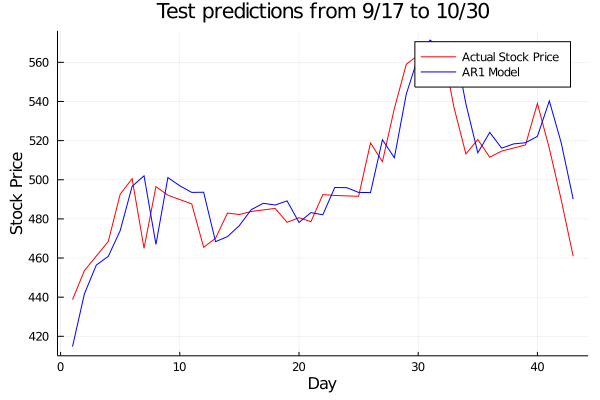

In [63]:
print("Zoom's ")
select_best_model(zoom)

Facebook's Selected Model: AR2 Model
Estimated Error: 3.826956268127506
Validation Error: 4.680419669045004

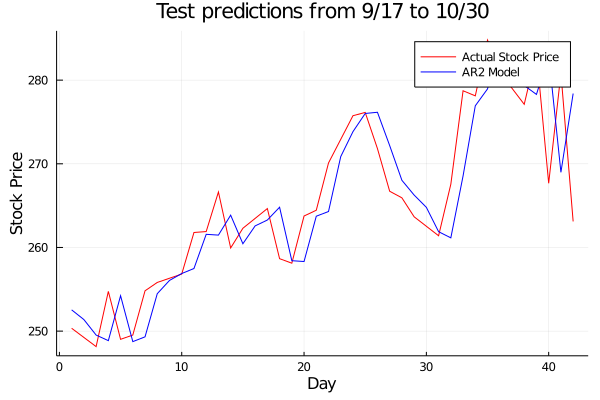

In [64]:
print("Facebook's ")
select_best_model(facebook)

Amazon's Selected Model: AR2 Model
Estimated Error: 42.435810489032576
Validation Error: 49.970204518918294

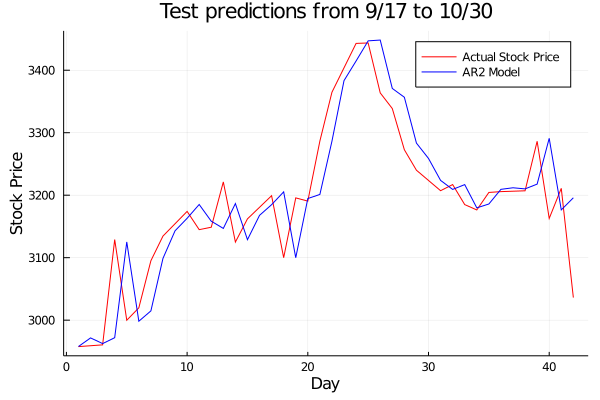

In [65]:
print("Amazon's ")
select_best_model(amazon)

Cisco's Selected Model: AR1 Model
Estimated Error: 0.625071861886649
Validation Error: 1.0374580629430235

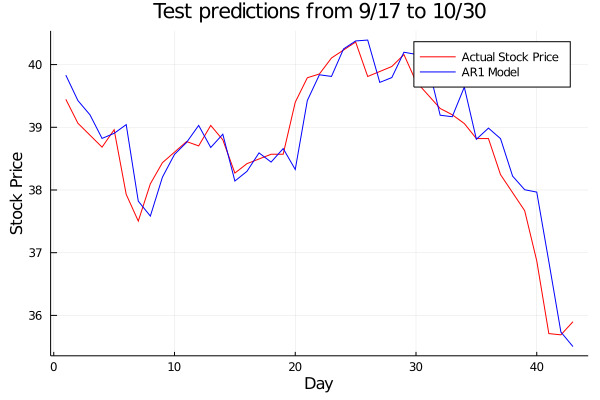

In [66]:
print("Cisco's ")
select_best_model(cisco)

Netflix's Selected Model: AR2 Model
Estimated Error: 8.303593939012512
Validation Error: 10.273612886575057

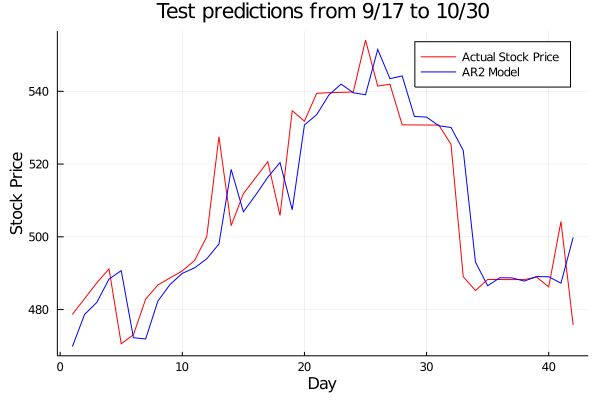

In [67]:
print("Netflix's ")
select_best_model(netflix)

Intel's Selected Model: AR2 Model
Estimated Error: 1.007447889538134
Validation Error: 1.3146488493522341

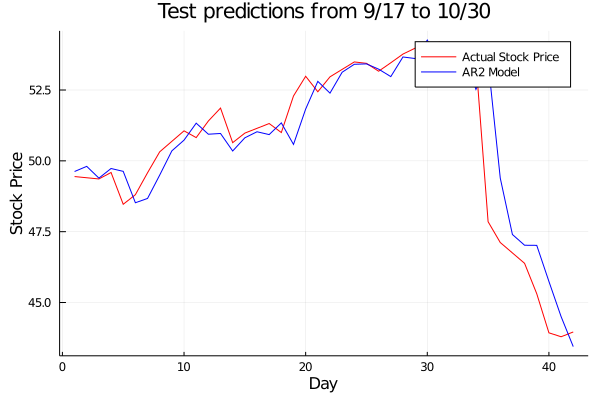

In [68]:
print("Intel's ")
select_best_model(intel)

Tesla's Selected Model: AR1 Model
Estimated Error: 7.80917364095355
Validation Error: 7.958677685873326

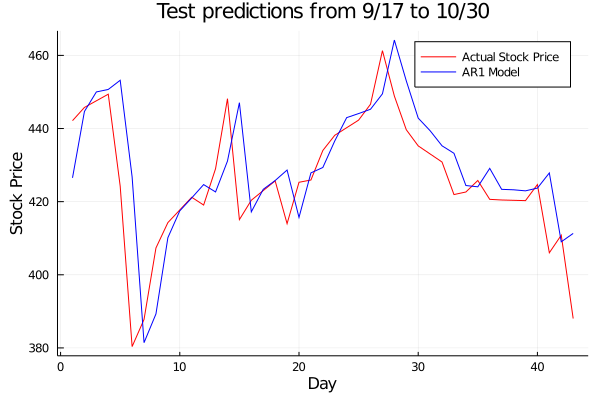

In [69]:
print("Tesla's ")
select_best_model(tesla)

Alibaba's Selected Model: AR2 Model
Estimated Error: 3.3373566118009657
Validation Error: 3.967953529672331

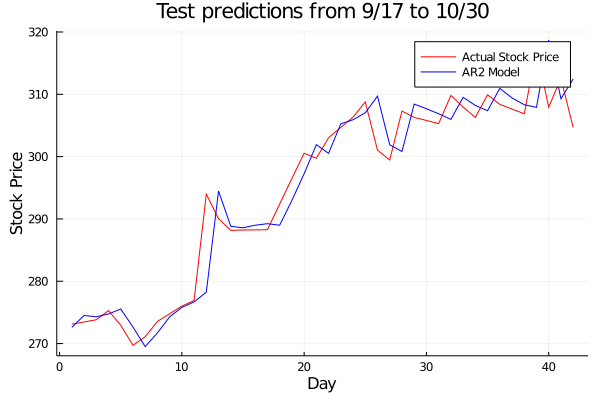

In [70]:
print("Alibaba's ")
select_best_model(alibaba)

Microsoft's Selected Model: AR2 Model
Estimated Error: 2.925146123058573
Validation Error: 3.6539537200112813

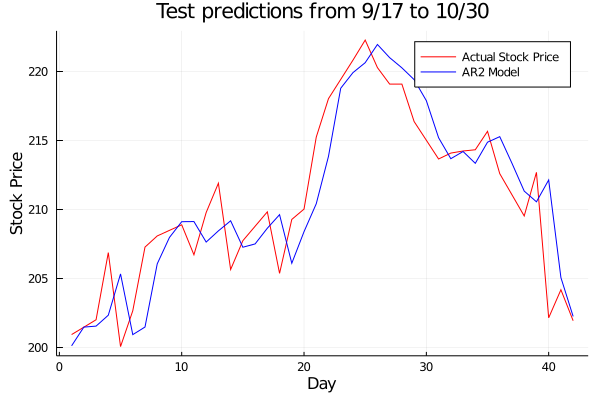

In [71]:
print("Microsoft's ")
select_best_model(microsoft)

Nvidia's Selected Model: AR2 Model
Estimated Error: 7.845266835164385
Validation Error: 9.720009298648566

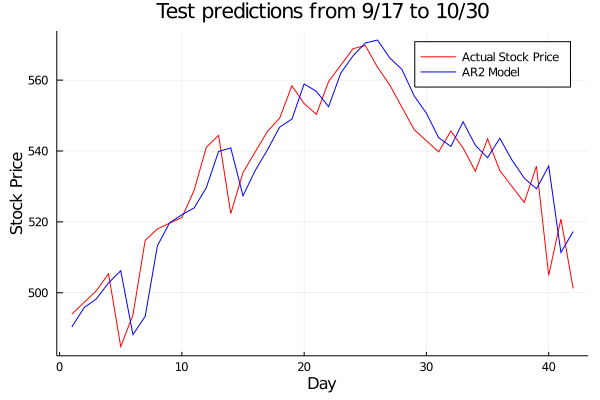

In [72]:
print("Nvidia's ")
select_best_model(nvidia)